In [58]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 14 14:16:04 2020

@author: thomas
"""

#MODULES
import os,sys
import re
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
from scipy.signal import savgol_filter
import pathlib
from matplotlib import animation
from IPython.display import display, Image, HTML
import plotly.graph_objects as go
import scipy.ndimage as ndimage

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['contour.negative_linestyle'] = 'solid'

In [65]:
#CONSTANTS
cwd_PYTHON = os.getcwd()+'/'
PERIOD = 0.1
DT = 5.0e-3
RADIUSLARGE = 0.002
RADIUSSMALL = 0.001
csfont = {'fontname':'Times New Roman'}
NX, NY = 1024, 1024
DX = (0.025/256.0)/RADIUSLARGE
print(DX)
LENGTH = 0.1
maxR = 0.05/RADIUSLARGE
print(maxR)
maxVal = 8.0
minVal = -maxVal

#Lists
#RLength
ThetaList=['0.0','22.5','45.0','67.5','90.0','112.5','135.0','157.5','180.0',
           '202.5','225.0','247.5','270.0','292.5','315.0','337.5']
HxList=['0.5','1.5','2.5','3.5','4.5','5.5','6.5','7.5','8.5','9.5','10.5','11.5','12.5']
HyList=['-13','-11','-9','-7','-5','-3','-1','1','3','5','7','9']
ReList = ['2','10']
allData = [None]*len(ReList)
endData = [None]*len(ReList)

0.048828125
25.0


In [76]:
# constructs a filepath for the pos data of Re = $Re
def pname(cwd,Re):
    #return cwd+"/pd.txt"
    #cwd = cwd_PYTHON
    return cwd+"/pd_Re{0}.txt".format(Re)

def GetPosData(cwd,time,Re):
    global RADIUSLARGE
    data = pd.read_csv(pname(cwd,Re),delimiter=' ')
    topData = data[data['idx'] == 6].copy()
    botData = data[data['idx'] == 19].copy()
    topData = topData.sort_values(by=['time'])
    botData = botData.sort_values(by=['time'])
    topData = topData.reset_index(drop=True)
    botData = botData.reset_index(drop=True)
    dictPos = {'xU':topData['x'],'yU':topData['y'],'xL':botData['x'],'yL':botData['y'],'time':topData['time']}
    pos = pd.DataFrame(data=dictPos)
    pos = pos[pos['time'] == time]
    pos = pos.reset_index(drop=True)
    pos['xU'] /= RADIUSLARGE
    pos['xL'] /= RADIUSLARGE
    pos['yU'] /= RADIUSLARGE
    pos['yL'] /= RADIUSLARGE
    return pos

def GetAvgFieldData(cwd,Re,idx):
    global RADIUSLARGE
    #Load position data
    #Columns
    #mx.flat my.flat avgW.flat avgP.flat avgUx.flat avgUy.flat
    fieldData = pd.read_csv(cwd+'Re%s_AVG_%04d.csv'%(Re,idx),delimiter=' ')
    print(fieldData.head())
    #All field values to a list
    mxList = fieldData['mx'].values.tolist()
    myList = fieldData['my'].values.tolist()
    WList  = fieldData['avgW'].values.tolist()
    PList  = fieldData['avgP'].values.tolist()
    UxList = fieldData['avgUx'].values.tolist()
    UyList = fieldData['avgUy'].values.tolist()
    #Convert lists to numpy arrays
    #Reshape them to be Nx x Ny
    Nx, Ny = 1024, 1024
    mxArr = np.array(mxList).reshape((Nx,Ny))/RADIUSLARGE
    myArr = np.array(myList).reshape((Nx,Ny))/RADIUSLARGE
    WArr  = np.array(WList).reshape((Nx,Ny))
    PArr  = np.array(PList).reshape((Nx,Ny))
    UxArr = np.array(UxList).reshape((Nx,Ny))/RADIUSLARGE
    UyArr = np.array(UyList).reshape((Nx,Ny))/RADIUSLARGE
    return (mxArr, myArr, WArr, PArr, UxArr, UyArr)

def ShiftSimulation(mx,my,pos):
    global RADIUSLARGE
    #Shift x and y by the CM location
    xCM = 0.8*pos.loc[0,'xU'] + 0.2*pos.loc[0,'xL']
    yCM = 0.8*pos.loc[0,'yU'] + 0.2*pos.loc[0,'yL']
    pos['xCM'] = xCM
    pos['yCM'] = yCM
    #Do the same for mx and my
    mx -= xCM
    my -= yCM
    #Shift pos data by xCM and yCM
    pos['xU'] -= xCM
    pos['xL'] -= xCM
    pos['yU'] -= yCM
    pos['yL'] -= yCM
    return (mx, my, pos)

In [129]:
def AddDiscsToPlot(ax,U,L,fill,faceColor,edgeColor,lineColor):
    print(U)
    #Add Discs
    circle1 = Circle((U[0], U[1]), 1.0, facecolor=faceColor,
                     linewidth=1,alpha=1.0,zorder=6,edgecolor=edgeColor,fill=fill,lw=3)
    ax.add_patch(circle1)
    circle2 = Circle((L[0], L[1]), 0.5, facecolor=faceColor,
                  linewidth=1,alpha=1.0,zorder=6,edgecolor=edgeColor,fill=fill,lw=3)
    ax.add_patch(circle2)
    #Add Swimmer "springs"
    ax.plot([U[0],L[0]],
         [U[1],L[1]],
         color=lineColor,linewidth=3,zorder=6)
    return
'''
def AddDiscsToPlot(ax,pos):
    #Add Discs
    circle1 = Circle((pos.loc[0,'xU'], pos.loc[0,'yU']), 1.0, facecolor=(0.25,)*3,
                     linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle1)
    circle2 = Circle((pos.loc[0,'xL'], pos.loc[0,'yL']), 0.5, facecolor=(0.25,)*3,
                  linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle2)
    #Add Swimmer "springs"
    ax.plot([pos.loc[0,'xU'],pos.loc[0,'xL']],
         [pos.loc[0,'yU'],pos.loc[0,'yL']],
         color=(0.25,)*3,linewidth=3,zorder=6)
    return
'''
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

def CalcPsi2D(fx,fy,NX,DX):
    #From here, we are going to calculate the stream function
    psi = np.zeros((NX,NX))
    for idx in range(1,NX):
        psi[idx,0] = psi[idx-1,0] - fy[idx,0]*DX
    for idy in range(1,NX):
        psi[:,idy] = psi[:,idy-1] + fx[:,idy]*DX
    
    return psi

def PlotSingleSwimmerFlow(ax,mx,my,W,Ux,Uy,pos):
    global DX,maxR,NX
    #Plot Streamlines
    psi = CalcPsi2D(Ux,Uy,NX,DX)
    psi2 = ndimage.gaussian_filter(psi, sigma=5.0, order=0)
    levels = MaxNLocator(nbins=21).tick_values(-1.0*max(abs(psi2.min()),psi2.max()), max(abs(psi2.min()),psi2.max()))
    ax.contour(mx,my,psi2,colors='k',extend='both',levels=levels,linewidths=1)
    #Plot Vorticity with imshow
    ax.imshow(W.T,cmap='bwr',extent=(-1.0*maxR-0.5*DX-pos.loc[0,'xCM'],maxR+0.5*DX-pos.loc[0,'xCM'],
                                     -1.0*maxR-0.5*DX-pos.loc[0,'yCM'],maxR+0.5*DX-pos.loc[0,'yCM']),
              origin='lower',vmin=-1.0,vmax=1.0,interpolation='bilinear')
    space = 8
    magU = np.hypot(Ux,Uy)
    nUx,nUy = Ux/magU,Uy/magU
    ax.quiver(mx[::space,::space],my[::space,::space],
              nUx[::space,::space],nUy[::space,::space],
              color='k',pivot='mid',angles='xy',scale_units='xy', scale=3,zorder=5)
    
    #Add swimmer
    #AddDiscsToPlot(ax,pos)
    AddDiscsToPlot(ax,np.array([pos.loc[0,'xU'],pos.loc[0,'yU']]),
                   np.array([pos.loc[0,'xL'],pos.loc[0,'yL']]),
                   True,(0.25,)*3,None,(0.25,)*3)
    ax.axis([minVal,maxVal,minVal,maxVal])
    return ax
    
    

     mx        my      avgW      avgP     avgUx     avgUy
0 -0.05 -0.050000  0.001692 -0.027819  0.000038 -0.000133
1 -0.05 -0.049902  0.001692 -0.027819  0.000038 -0.000133
2 -0.05 -0.049805  0.001692 -0.027819  0.000038 -0.000133
3 -0.05 -0.049707  0.001692 -0.027819  0.000038 -0.000133
4 -0.05 -0.049609  0.001692 -0.027819  0.000038 -0.000133
[-6.8000e-05  5.0013e-01]
[ 2.89644661 -2.85355339]
[ 2.29340265 -3.55595787]
[ 3.89644661 -5.85355339]
[ 0.0535556 -4.09573  ]
[-0.10355339 -5.85355339]
[-4.64238602 -1.89468178]
[1.89644661 3.14644661]
[-0.00942172  2.86755   ]


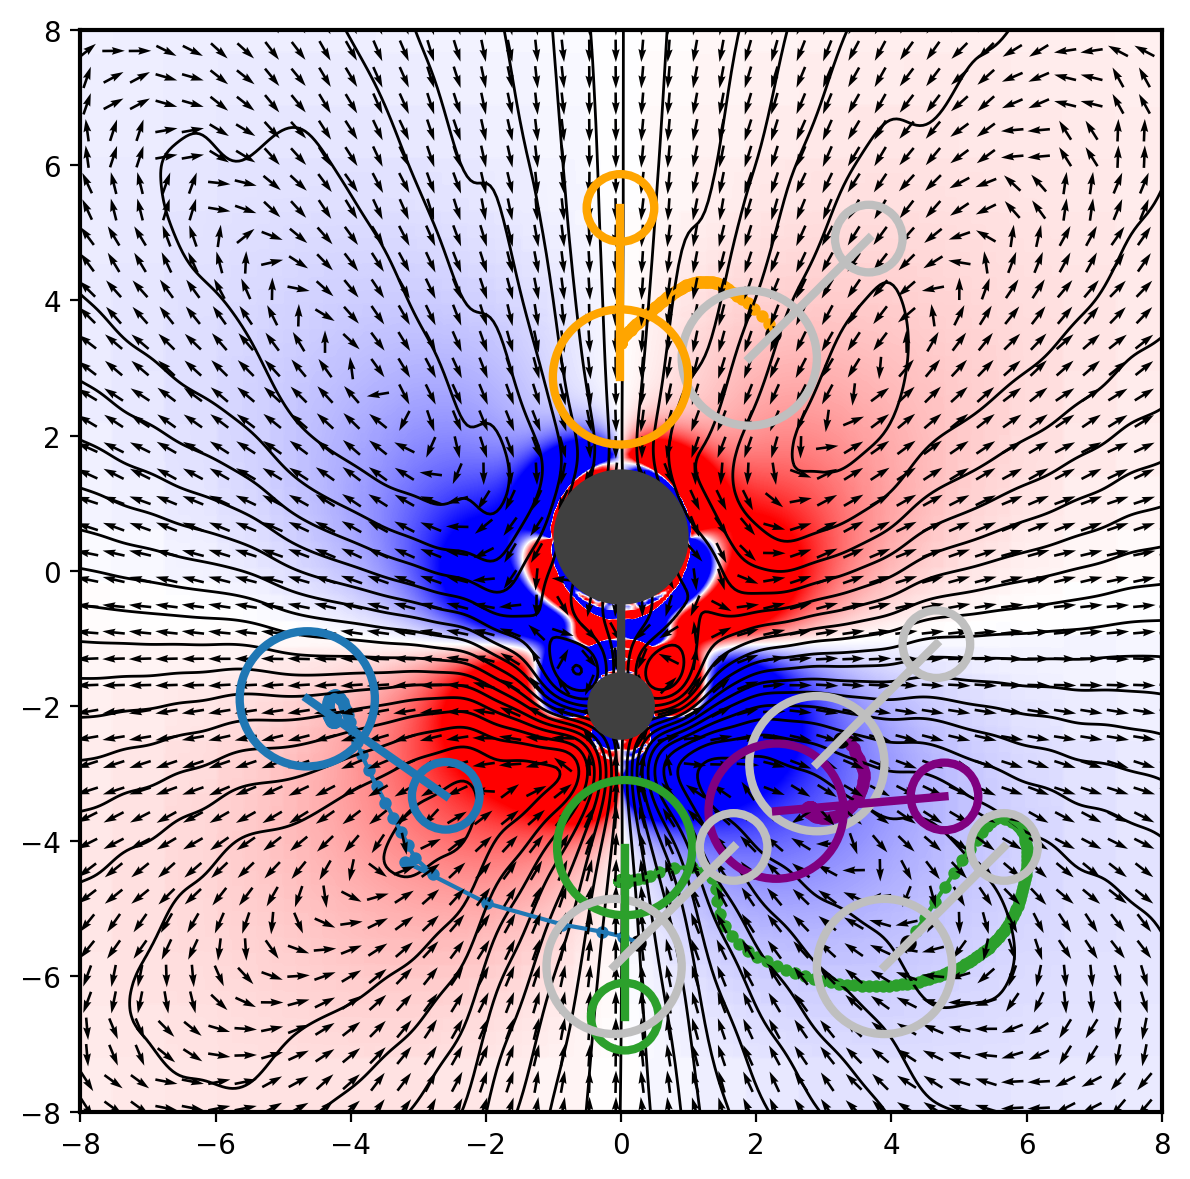

     mx        my          avgW      avgP     avgUx     avgUy
0 -0.05 -0.050000 -6.168500e-07 -0.027237  0.000002 -0.000004
1 -0.05 -0.049902 -6.168500e-07 -0.027237  0.000002 -0.000004
2 -0.05 -0.049805 -6.168500e-07 -0.027237  0.000002 -0.000004
3 -0.05 -0.049707 -6.168500e-07 -0.027237  0.000002 -0.000004
4 -0.05 -0.049609 -6.168500e-07 -0.027237  0.000002 -0.000004
[0.001384 0.500009]
[ 5.39644661 -3.85355339]
[ 2.5989  -2.14084]
[ 0.39644661 -6.85355339]
[-3.10068481 -0.29982715]
[3.89644661 3.14644661]
[0.0556663 2.8467   ]


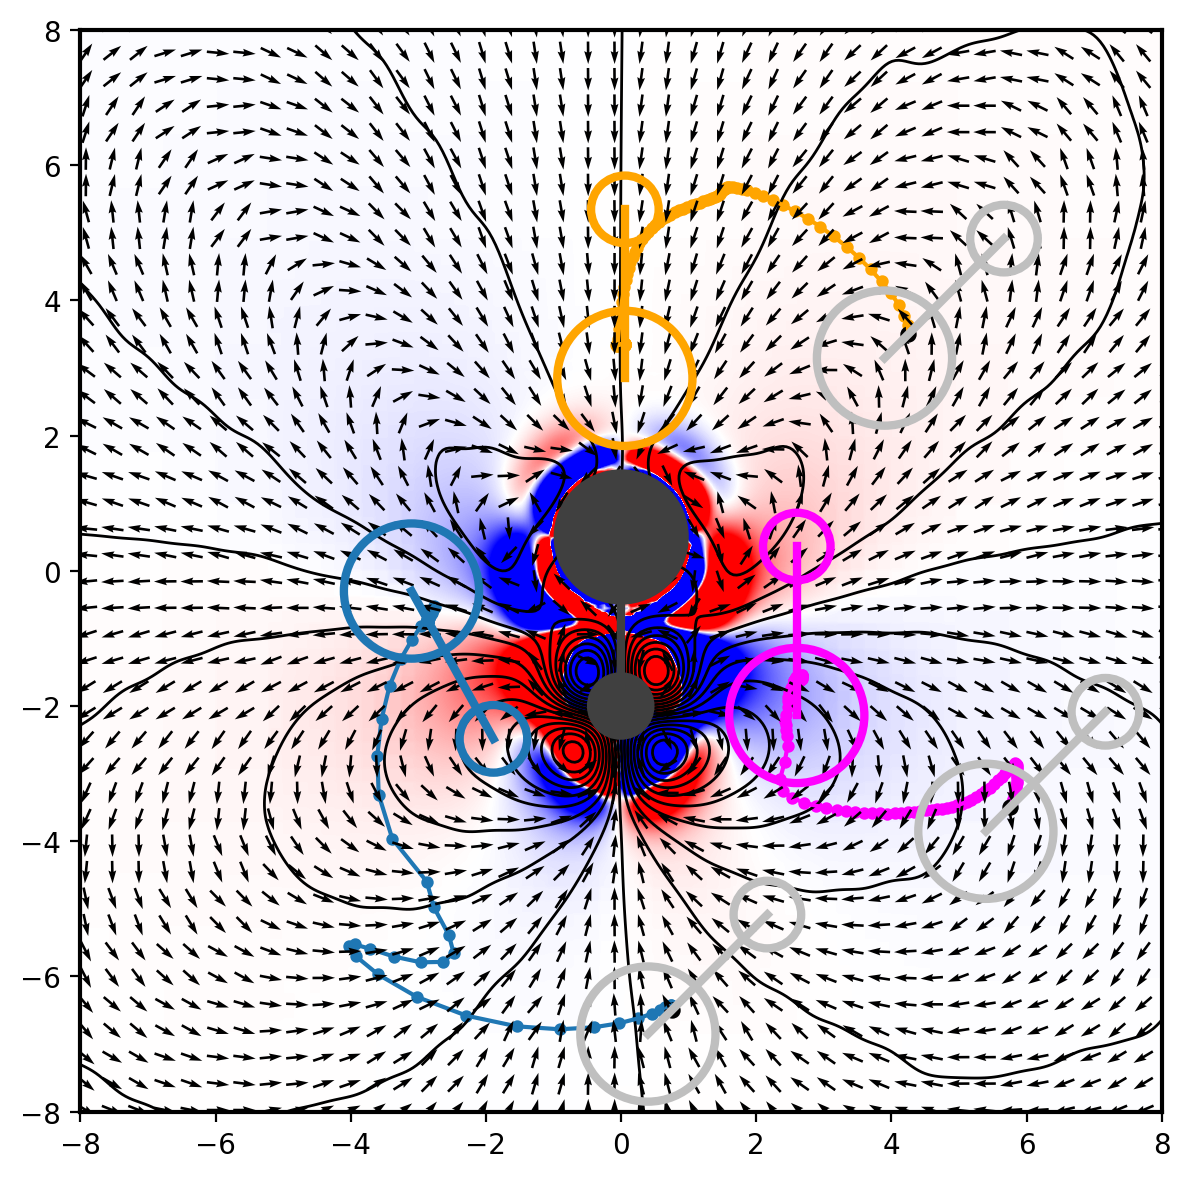

In [138]:
#Plot Trajectory onto flow field for single swimmer. See if streamlines line up with the motion of the swimmer.
perNumber=100
for Re in ReList:
    cwd_FIGS = cwd_PYTHON+'../Figures/FlowTrajectory/Re{0}/'.format(Re)
    pathlib.Path(cwd_FIGS).mkdir(parents=True, exist_ok=True)
    cwd_Re = cwd_PYTHON+'../../FieldData/SingleBot/Re{0}/'.format(Re)#
    cwd_POS = cwd_Re
    #Create Figure
    nRows, nCols = 1, 1
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, num=0,figsize=(6,6),dpi=200)
    #First obtain flow field of single swimmer
    mx,my,avgW,avgP,avgUx,avgUy = GetAvgFieldData(cwd_Re,Re,perNumber)
    time = np.round(0.05 + perNumber*PERIOD,2)
    posData = GetPosData(cwd_POS,time,Re)
    mx, my, posData = ShiftSimulation(mx,my,posData)
    #Plot flow field 
    ax = PlotSingleSwimmerFlow(ax,mx,my,avgW,avgUx,avgUy,posData)
    #Now that we have the flow field, we need to superimpose trajectories
    Theta = 135.0
    #We choose Theta to be 135.0 because that is an angle where all Re=2 states form
    #We will also choose a Theta like this for Re=10
    if Re == '2':
        stateList = ['L','SF','V','HB']
    elif Re == '10':
        stateList = ['O','V','HB']
    for idState in range(len(stateList)):
        state = stateList[idState]
        allData = pd.read_csv('all{0}Data_Re{1}_.csv'.format(state,Re),delimiter=' ')
        thetaData = allData[allData['parThetaBW'] <= float(Theta)+0.01].copy()
        thetaData = thetaData[thetaData['parThetaBW'] >= float(Theta)-0.01].copy()
        #Select specific trajectories here
        if Re == '2':
            if state == 'L':
                parHx = 3.25
                parHy = -2.5
                trajColor = 'purple'
                ThetaFinal = 95.0
            elif state == 'SF':
                parHx = 4.25
                parHy = -5.5
                trajColor = 'tab:green'
                ThetaFinal = 0.0
            elif state == 'V':
                parHx = 0.25
                parHy = -5.5
                trajColor = 'tab:blue'
                ThetaFinal = 55.0
            elif state == 'HB':
                parHx = 2.25
                parHy = 3.5   
                trajColor = 'orange'
                ThetaFinal = 180.0
        elif Re == '10':
            if state == 'O':
                parHx = 5.75
                parHy = -3.5
                trajColor = 'magenta'
                ThetaFinal = 180.0
            elif state == 'V':
                parHx = 0.75
                parHy = -6.5
                trajColor = 'tab:blue'
                ThetaFinal = 29.0
            elif state == 'HB':
                parHx = 4.25
                parHy = 3.5
                trajColor = 'orange'
                ThetaFinal = 180.0
        #Further subset data by chosen initial conditions
        HxData = thetaData[thetaData['parHx'] <= parHx + 0.01].copy()
        HxData = HxData[HxData['parHx'] >= parHx - 0.01].copy()
        data = HxData[HxData['parHy'] <= parHy + 0.01].copy()
        data = data[data['parHy'] >= parHy - 0.01].copy()
        data = data.reset_index(drop=True)
        #Plot trajectory
        ax.plot(data['Hx'],data['Hy'],color=trajColor)
        ax.scatter(data['Hx'],data['Hy'],s=12,color=trajColor)
        ax.scatter(data.loc[0,'Hx'],data.loc[0,'Hy'],s=24,color='k')
        AddDiscsToPlot(ax,np.array([data.loc[0,'Hx']-0.5*np.sin(Theta*np.pi/180.0),
                                    data.loc[0,'Hy']+0.5*np.cos(Theta*np.pi/180.0)]),
                   np.array([data.loc[0,'Hx']+2.0*np.sin(Theta*np.pi/180.0),
                             data.loc[0,'Hy']-2.0*np.cos(Theta*np.pi/180.0)]),
                   False,None,(0.75,)*3,(0.75,)*3)
        AddDiscsToPlot(ax,np.array([data.loc[len(data['time'])-1,'Hx']-0.5*np.sin(ThetaFinal*np.pi/180.0),
                                    data.loc[len(data['time'])-1,'Hy']+0.5*np.cos(ThetaFinal*np.pi/180.0)]),
                   np.array([data.loc[len(data['time'])-1,'Hx']+2.0*np.sin(ThetaFinal*np.pi/180.0),
                             data.loc[len(data['time'])-1,'Hy']-2.0*np.cos(ThetaFinal*np.pi/180.0)]),
                   False,None,trajColor,trajColor)
    fig.tight_layout()
    plt.show()
    fig.savefig(cwd_FIGS+'Re{0}_SSFlow_And_PairTrajectories.png'.format(Re))
    fig.clf()
    plt.close()


    